# Stock Prediction Based On LSTM Deep Learning

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. The particular network architecture I employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

In Part 1, I used a small dataset of Apple's stock from Feb. 2013 to Feb. 2018 to predicted Apple's stock price 7 days in advance. This part is the experimental part, study to apply the deep learning model on a stock.

In Part 2, based on the stocks of 4 noteworthy sectors in the last 10 years, a deep learning prediction model was established. The second part is the focus of the whole project. It establishes prediction models for the technology sector, financial sector, transportation sector and health care sector respectively, so as to explore their development trends and predict future changes.

Part 3 includes some other interesting points that I discovered during the exploration.


# Data Source

The data in Part 1 is loaded from [Super DataScience](https://www.superdatascience.com/deep-learning/).

The data in Part 2 is loaded from Yahoo Finance.


# Part 1: Predict stock on a small dataset.

This is an experimental part. In this part, I only introduce the stock data of Apple Inc. to build the model. The completion of this section means the completion of the minimum goal in the final project.

## Loading the data


In [1]:
!pip install plotly==4.9.0

     |████████████████████████████████| 12.9MB 209kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importing the training set
dataset = data = pd.read_csv('/content/drive/MyDrive/ADL/final project/all_stocks_5yr.csv')
dataset_cl = dataset[dataset['Name']=='SWKS'].close.values


Pre-processing step is needed to prepare data for use with an RNN model.  To avoid serious numerical issues I normalize the series to lie in the range [0,1].

In [5]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Cutting our time series into sequences

The time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [6]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 7)


## Split training and testing sets

In order to perform proper testing on our dataset I used the first 80% data as training set and the left 20% data as testing set.  This is a time series related data so cannot randomly picked testing dataset.

In [7]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1000
251
1000
251


## Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, I begin setting up RNN.  Keras is used to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 64 hidden units, where the input_shape = (7,1)
- layer 2 uses a fully connected module with one unit
- Loss function: MSE 

In [8]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [9]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [10]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

epoch 0, loss 0.3603740930557251, eval loss 0.8890787363052368
epoch 1, loss 0.3274204730987549
epoch 2, loss 0.29503297805786133
epoch 3, loss 0.26343703269958496
epoch 4, loss 0.2317320853471756
epoch 5, loss 0.19942495226860046
epoch 6, loss 0.1661093533039093
epoch 7, loss 0.13209651410579681
epoch 8, loss 0.09910418838262558
epoch 9, loss 0.06869876384735107
epoch 10, loss 0.04732608050107956
epoch 11, loss 0.04745753854513168
epoch 12, loss 0.07182933390140533
epoch 13, loss 0.08309563249349594
epoch 14, loss 0.07263821363449097
epoch 15, loss 0.05536811798810959
epoch 16, loss 0.0441778227686882
epoch 17, loss 0.03934089466929436
epoch 18, loss 0.038826100528240204
epoch 19, loss 0.04098556935787201
epoch 20, loss 0.04275502637028694, eval loss 0.1582983285188675
epoch 21, loss 0.04357016086578369
epoch 22, loss 0.04276389628648758
epoch 23, loss 0.040677182376384735
epoch 24, loss 0.03635267913341522
epoch 25, loss 0.0313166007399559
epoch 26, loss 0.026032842695713043
epoch 27

In [12]:
rnn.out.weight 

Parameter containing:
tensor([[ 0.0385,  0.0966,  0.1125, -0.1159,  0.1108, -0.0933, -0.0027, -0.0846,
          0.0014,  0.0281, -0.0052,  0.1337, -0.0770, -0.0737, -0.0771,  0.0595,
          0.0506, -0.0890,  0.0884, -0.0262, -0.0650, -0.0174,  0.0885,  0.0049,
         -0.0353, -0.0297,  0.0512, -0.0722,  0.0589,  0.0070,  0.0579,  0.1166,
          0.0729,  0.1012, -0.0581,  0.1192, -0.0600, -0.0919,  0.0655, -0.0721,
          0.1168,  0.1038,  0.1124,  0.0090,  0.0462, -0.0693, -0.1118, -0.0352,
          0.0689, -0.0029,  0.0152,  0.0478, -0.0566, -0.0324, -0.0804,  0.0888,
          0.0854, -0.0495,  0.0234, -0.0119,  0.1039, -0.1064, -0.1011,  0.0432]],
       device='cuda:0', requires_grad=True)

In [13]:
for param in rnn.parameters():
    print(param.data)

tensor([[ 0.0348, -0.0375, -0.0501,  ...,  0.0015, -0.0102,  0.0543],
        [ 0.0127,  0.0437, -0.0740,  ..., -0.0229, -0.0153,  0.1455],
        [ 0.0446,  0.1015,  0.0975,  ...,  0.0439, -0.0549, -0.0562],
        ...,
        [-0.0898,  0.0763,  0.0143,  ...,  0.0836, -0.0133,  0.1313],
        [ 0.0936,  0.1106, -0.0598,  ...,  0.1120,  0.0869,  0.0683],
        [-0.0671,  0.0527, -0.0664,  ..., -0.0290,  0.1650,  0.1116]],
       device='cuda:0')
tensor([[ 0.0226,  0.0303,  0.1299,  ..., -0.0285, -0.0597, -0.0312],
        [-0.0922, -0.0520,  0.1072,  ..., -0.0819, -0.0767,  0.0121],
        [ 0.0353, -0.0640,  0.0778,  ..., -0.0065,  0.0407, -0.0816],
        ...,
        [-0.0844, -0.0521,  0.1222,  ...,  0.1187,  0.0756, -0.0218],
        [-0.0238, -0.0318,  0.0997,  ...,  0.0533, -0.0133,  0.0225],
        [-0.1095,  0.0376,  0.0129,  ..., -0.0888, -0.0915,  0.0198]],
       device='cuda:0')
tensor([-0.0178,  0.0783,  0.1321, -0.0020,  0.0718,  0.0264, -0.0530, -0.0094,
    

## Checking model performance

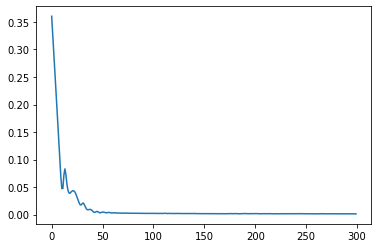

In [14]:
plt.plot(history)

In [15]:
X_test[0]

array([[0.75733001, 0.74433354, 0.74433354, 0.73778332, 0.74246205,
        0.74069453, 0.74474943]])

In [16]:
rnn.eval()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [17]:
test_predict_cpu.shape

(251, 1, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Unrecognized location 'bottom'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  This is separate from the ipykernel package so we can avoid doing imports until


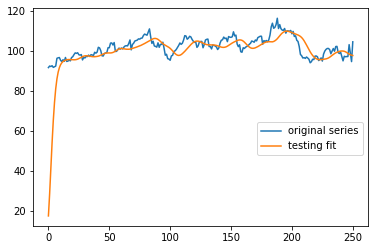

In [19]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))
plt.legend(['original series','testing fit'], loc='bottom', bbox_to_anchor=(1, 0.5))

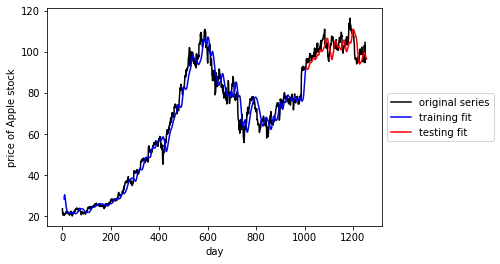

In [20]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of Apple stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


From the plot above, both the training and testing set fit are very well.

# Part 2:

This part pulls 4 [majoy sectors](https://www.fxcm.com/markets/insights/the-11-sectors-of-the-sp-500/) data(Technology, Finicance, Transportation and Medical) from 2010.12 to 2020.12.

First of all, using the model learned in the first part, the stock transfer learning was carried out for the four sectors, and the parameter adjustment and model optimization were carried out for the model whose learning results did not achieve the expected performance. Then I focus on the presentation of specific plates and specific periods in the research process for individual modeling and in-depth research.

The completion of this part indicates the achievement of my expected goal.

## Loading the data

Loading the 4 sectors stock data in S&P500 from Yahoo Finance.

- XLK: Technology
- XLV: Health Care
- XLF: Finicial
- XTN: Transportation

In [1]:
!pip install pandas-datareader

In [2]:
import pandas_datareader 
import pandas_datareader.data as web
import datetime

In [23]:
start = datetime.datetime(2010, 12, 1)
end = datetime.datetime(2020, 12, 1)
pd.set_option('display.precision', 2)
xlk = web.DataReader("XLK", 'yahoo', start, end)

In [24]:
type(xlk)

pandas.core.frame.DataFrame

In [25]:
xlk.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-01,24.53,24.24,24.30,24.46,1.07e+07,20.79
2010-12-02,24.77,24.47,24.49,24.75,9.63e+06,21.03
2010-12-03,24.82,24.61,24.62,24.81,9.18e+06,21.09
2010-12-06,24.87,24.75,24.78,24.81,6.44e+06,21.09
2010-12-07,25.10,24.82,25.10,24.84,9.91e+06,21.11
2010-12-08,25.05,24.81,24.93,25.05,9.01e+06,21.29
2010-12-09,25.16,24.97,25.15,25.07,6.23e+06,21.31
2010-12-10,25.21,25.04,25.12,25.19,5.82e+06,21.41
2010-12-13,25.32,25.12,25.29,25.14,6.90e+06,21.37


In [26]:
xlk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2010-12-01 to 2020-12-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2518 non-null   float64
 1   Low        2518 non-null   float64
 2   Open       2518 non-null   float64
 3   Close      2518 non-null   float64
 4   Volume     2518 non-null   float64
 5   Adj Close  2518 non-null   float64
dtypes: float64(6)
memory usage: 137.7 KB


In [27]:
xlk.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2518.00,2518.00,2518.00,2518.00,2.52e+03,2518.00
mean,51.51,50.81,51.17,51.19,1.07e+07,48.45
std,24.09,23.60,23.86,23.86,6.45e+06,24.88
min,23.03,22.47,22.78,22.52,2.19e+06,19.35
25%,31.64,31.36,31.51,31.48,6.84e+06,27.87
50%,43.00,42.55,42.80,42.80,9.06e+06,39.54
75%,67.98,66.79,67.45,67.53,1.26e+07,65.32
max,127.72,124.81,127.71,127.03,6.83e+07,126.75


In [28]:
xlk.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-01,24.53,24.24,24.30,24.46,1.07e+07,20.79
2010-12-02,24.77,24.47,24.49,24.75,9.63e+06,21.03
2010-12-03,24.82,24.61,24.62,24.81,9.18e+06,21.09
2010-12-06,24.87,24.75,24.78,24.81,6.44e+06,21.09
2010-12-07,25.10,24.82,25.10,24.84,9.91e+06,21.11


In [29]:
xlf = web.DataReader("XLF", 'yahoo', start, end)
xlv = web.DataReader("XLV",'yahoo',start,end)
xtn = web.DataReader("XTN",'yahoo',start,end)

In [30]:
xlf.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-01,11.99,11.88,11.92,11.98,1.02e+08,7.65
2010-12-02,12.31,12.02,12.04,12.29,1.40e+08,7.85
2010-12-03,12.36,12.14,12.21,12.33,1.12e+08,7.88
2010-12-06,12.36,12.25,12.30,12.32,6.49e+07,7.86
2010-12-07,12.49,12.30,12.49,12.33,1.32e+08,7.88


In [31]:
xlv.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-12-01,30.90,30.61,30.61,30.85,8.57e+06,25.91
2010-12-02,31.09,30.84,30.90,31.09,5.52e+06,26.11
2010-12-03,31.11,30.94,30.96,31.09,7.77e+06,26.11
2010-12-06,31.02,30.86,30.98,30.89,5.09e+06,25.95
2010-12-07,31.13,30.87,31.11,30.91,6.94e+06,25.96


In [32]:
xtn.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-01-27,25.79,25.52,25.55,25.75,44200.0,23.88
2011-01-28,25.75,25.75,25.75,25.75,0.0,23.88
2011-01-31,25.02,24.94,24.94,25.02,400.0,23.21
2011-02-01,25.34,25.20,25.20,25.34,800.0,23.50
2011-02-02,25.03,24.85,25.03,24.85,600.0,23.05


### Visualizing the data



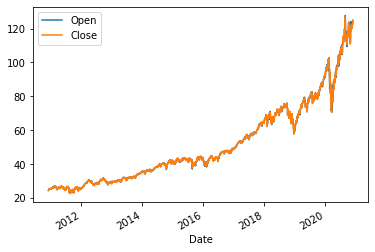

In [33]:
xlk.plot(y=['Open', 'Close'])

I decide to use the close price as the goal variable.


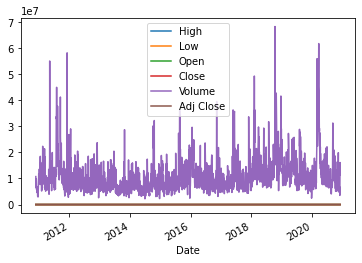

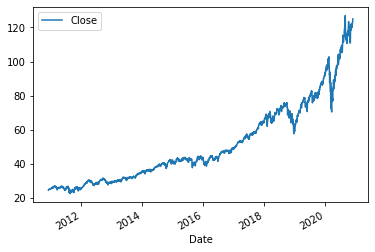

In [34]:
xlk.plot()
xlk.plot(y = ['Close'])

Check the performance of the four sectors over the last 10 years.

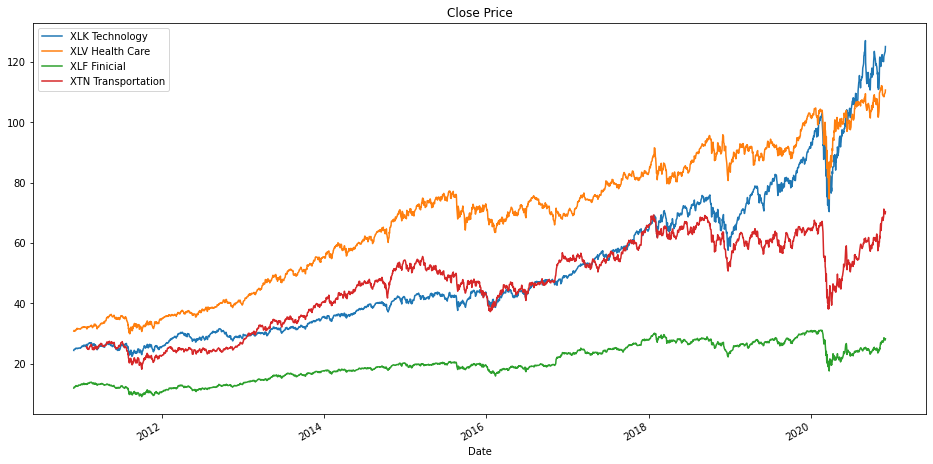

In [35]:
xlk['Close'].plot(label='XLK Technology',figsize=(16,8),title='Close Price')
xlv['Close'].plot(label='XLV Health Care')
xlf['Close'].plot(label='XLF Finicial')
xtn['Close'].plot(label='XTN Transportation')
plt.legend()



### Predict the close price

#### Change the data form

In [36]:
xlk_cl = xlk.Close.values
xlv_cl = xlv.Close.values
xlf_cl = xlf.Close.values
xtn_cl = xtn.Close.values

In [37]:
# scale the data
xlk_cl = xlk_cl.reshape(xlk_cl.shape[0], 1)
xlk_cl = sc.fit_transform(xlk_cl)

xlv_cl = xlv_cl.reshape(xlv_cl.shape[0], 1)
xlv_cl = sc.fit_transform(xlv_cl)

xlf_cl = xlf_cl.reshape(xlf_cl.shape[0], 1)
xlf_cl = sc.fit_transform(xlf_cl)

xtn_cl = xtn_cl.reshape(xtn_cl.shape[0], 1)
xtn_cl = sc.fit_transform(xtn_cl)

#### Cutting the time series into sequences

In [38]:
xlk_X, xlk_y = processData(xlk_cl, 7)
xlv_X, xlv_y = processData(xlv_cl, 7)
xlf_X, xlf_y = processData(xlf_cl, 7)
xtn_X, xtn_y = processData(xtn_cl, 7)

#### Split training and testing sets

In [39]:
# For xlk
xlk_X_train, xlk_X_test = xlk_X[:int(xlk_X.shape[0]*0.80)],xlk_X[int(xlk_X.shape[0]*0.80):]
xlk_y_train, xlk_y_test = xlk_y[:int(xlk_y.shape[0]*0.80)],xlk_y[int(xlk_y.shape[0]*0.80):]
print(xlk_X_train.shape[0])
print(xlk_X_test.shape[0])
print(xlk_y_train.shape[0])
print(xlk_y_test.shape[0])

# reshaping
xlk_X_train = np.reshape(xlk_X_train, (xlk_X_train.shape[0], 1, xlk_X_train.shape[1]))
xlk_X_test = np.reshape(xlk_X_test, (xlk_X_test.shape[0], 1, xlk_X_test.shape[1]))

2008
502
2008
502


In [40]:
# For xlv
xlv_X_train, xlv_X_test = xlv_X[:int(xlv_X.shape[0]*0.80)],xlv_X[int(xlv_X.shape[0]*0.80):]
xlv_y_train, xlv_y_test = xlv_y[:int(xlv_y.shape[0]*0.80)],xlv_y[int(xlv_y.shape[0]*0.80):]

# reshaping
xlv_X_train = np.reshape(xlv_X_train, (xlv_X_train.shape[0], 1, xlv_X_train.shape[1]))
xlv_X_test = np.reshape(xlv_X_test, (xlv_X_test.shape[0], 1, xlv_X_test.shape[1]))

In [41]:
# For xlf
xlf_X_train, xlf_X_test = xlf_X[:int(xlf_X.shape[0]*0.80)],xlf_X[int(xlf_X.shape[0]*0.80):]
xlf_y_train, xlf_y_test = xlf_y[:int(xlf_y.shape[0]*0.80)],xlf_y[int(xlf_y.shape[0]*0.80):]

# reshaping
xlf_X_train = np.reshape(xlf_X_train, (xlf_X_train.shape[0], 1, xlf_X_train.shape[1]))
xlf_X_test = np.reshape(xlf_X_test, (xlf_X_test.shape[0], 1, xlf_X_test.shape[1]))

In [42]:
# For xtn
xtn_X_train, xtn_X_test = xtn_X[:int(xtn_X.shape[0]*0.80)],xtn_X[int(xtn_X.shape[0]*0.80):]
xtn_y_train, xtn_y_test = xtn_y[:int(xtn_y.shape[0]*0.80)],xtn_y[int(xtn_y.shape[0]*0.80):]

# reshaping
xtn_X_train = np.reshape(xtn_X_train, (xtn_X_train.shape[0], 1, xtn_X_train.shape[1]))
xtn_X_test = np.reshape(xtn_X_test, (xtn_X_test.shape[0], 1, xtn_X_test.shape[1]))

#### Build and run an RNN regression model

##### For xlk

In [43]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [44]:
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [46]:
def epochTest(num_epochs,inputs_cuda,labels_cuda,X_test_cuda,y_test_cuda,hidden_state,history):
  for epoch in range(num_epochs):
      rnn.train()
      output, _ = rnn(inputs_cuda, hidden_state) 

      loss = criterion(output[:,0,:].view(-1), labels_cuda)
      optimiser.zero_grad()
      loss.backward()                     # back propagation
      optimiser.step()                    # update the parameters
    
      if epoch % 20 == 0:
          rnn.eval()
          test_output, _ = rnn(X_test_cuda, hidden_state)
          test_loss = criterion(test_output.view(-1), y_test_cuda)
          print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
      else:
          print('epoch {}, loss {}'.format(epoch, loss.item()))
      history.append(loss.item())

In [47]:
xlk_history = []
xlk_X_test_cuda = torch.tensor(xlk_X_test).float().cuda()
xlk_y_test_cuda = torch.tensor(xlk_y_test).float().cuda()

# we use all the data in one batch
xlk_inputs_cuda = torch.tensor(xlk_X_train).float().cuda()
xlk_labels_cuda = torch.tensor(xlk_y_train).float().cuda()


epochTest(num_epochs,xlk_inputs_cuda,xlk_labels_cuda,xlk_X_test_cuda,xlk_y_test_cuda,hidden_state,xlk_history)

epoch 0, loss 0.03735261783003807, eval loss 0.33066073060035706
epoch 1, loss 0.02895619347691536
epoch 2, loss 0.022615300491452217
epoch 3, loss 0.01842554658651352
epoch 4, loss 0.016589032486081123
epoch 5, loss 0.016974734142422676
epoch 6, loss 0.018626542761921883
epoch 7, loss 0.019275300204753876
epoch 8, loss 0.018653828650712967
epoch 9, loss 0.01734502986073494
epoch 10, loss 0.01598736271262169
epoch 11, loss 0.015109204687178135
epoch 12, loss 0.014448060654103756
epoch 13, loss 0.013989303261041641
epoch 14, loss 0.01378158200532198
epoch 15, loss 0.013429961167275906
epoch 16, loss 0.012995180673897266
epoch 17, loss 0.012151558883488178
epoch 18, loss 0.010998416692018509
epoch 19, loss 0.009533122181892395
epoch 20, loss 0.007839662954211235, eval loss 0.053752657026052475
epoch 21, loss 0.006025082431733608
epoch 22, loss 0.004726165905594826
epoch 23, loss 0.00475730188190937
epoch 24, loss 0.0049041504971683025
epoch 25, loss 0.00299032568000257
epoch 26, loss 0.0

In [47]:
rnn.out.weight 

Parameter containing:
tensor([[-0.0182, -0.1223, -0.0676, -0.0717,  0.0704,  0.0844,  0.0472,  0.0579,
          0.0677, -0.1250, -0.0091,  0.0949,  0.0482,  0.0393,  0.0932,  0.0687,
          0.0465, -0.0909,  0.0132,  0.0522, -0.0991,  0.0493, -0.0372, -0.0804,
          0.0725, -0.0739,  0.0043, -0.0752, -0.1152,  0.0908, -0.0290, -0.0088,
         -0.0633, -0.0944,  0.0831, -0.0877,  0.0011,  0.0210, -0.1059,  0.0540,
          0.0445, -0.0299, -0.1250, -0.0746,  0.1284,  0.0713,  0.0439, -0.0061,
          0.0546, -0.0575, -0.0824, -0.0535, -0.0090,  0.0119,  0.0594, -0.0081,
         -0.0636,  0.0631,  0.0308, -0.0140, -0.0882,  0.1129, -0.0582,  0.0126]],
       device='cuda:0', requires_grad=True)

In [48]:
for param in rnn.parameters():
    print(param.data)

tensor([[ 0.1574,  0.0964, -0.0063,  ...,  0.0258, -0.0558,  0.0302],
        [ 0.0009, -0.0247, -0.0852,  ..., -0.0104,  0.0293,  0.1321],
        [ 0.0694,  0.0232, -0.0432,  ..., -0.1327,  0.0868, -0.1128],
        ...,
        [ 0.1290,  0.1318,  0.0467,  ..., -0.1009, -0.0542,  0.0264],
        [ 0.0835, -0.0957,  0.1323,  ..., -0.1029, -0.1144,  0.0901],
        [ 0.0037, -0.0502,  0.0510,  ..., -0.0355,  0.0872,  0.0364]],
       device='cuda:0')
tensor([[-0.0093, -0.0394,  0.1180,  ..., -0.0061, -0.0480,  0.1313],
        [-0.0421, -0.0848,  0.0990,  ..., -0.0244,  0.0335, -0.0277],
        [ 0.0933, -0.1040,  0.0477,  ...,  0.0822,  0.0809, -0.0173],
        ...,
        [ 0.1223, -0.1073, -0.0657,  ...,  0.1089,  0.0170,  0.1117],
        [-0.0415,  0.0132, -0.0211,  ..., -0.0353,  0.1028, -0.0011],
        [ 0.0881,  0.0113,  0.0886,  ..., -0.0438,  0.0787,  0.0565]],
       device='cuda:0')
tensor([ 0.1335, -0.0023,  0.0963, -0.0075, -0.0871,  0.0172, -0.0449,  0.0307,
    

Check the model performance

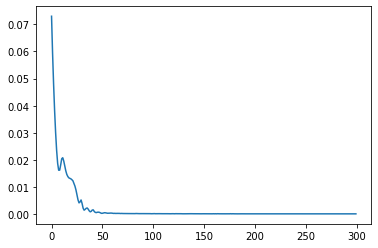

In [49]:
plt.plot(xlk_history)

In [50]:
xlk_X_test[0]

array([[0.40331067, 0.39766531, 0.41153956, 0.4127835 , 0.43479092,
        0.42847578, 0.43459959]])

In [48]:
rnn.eval()
xlk_test_predict, _ = rnn(xlk_X_test_cuda,hidden_state)
xlk_test_predict_cpu = xlk_test_predict.cpu().detach().numpy()

In [49]:
xlk_test_predict_cpu.shape

(502, 1, 1)

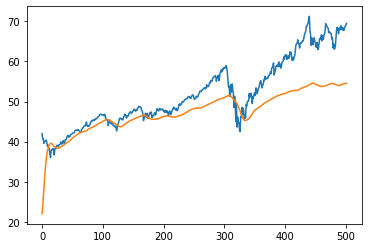

In [50]:
plt.plot(sc.inverse_transform(xlk_y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(xlk_test_predict_cpu.reshape(-1,1)))

In [51]:
from sklearn.metrics import mean_squared_error
print(f"RMSE：{np.sqrt(mean_squared_error(sc.inverse_transform(xlk_test_predict_cpu.reshape(-1,1)), sc.inverse_transform(xlk_y_test.reshape(-1,1))))}")

RMSE：6.462406040179517


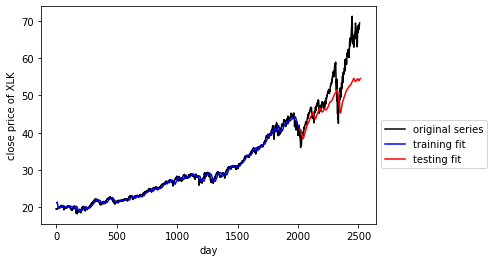

In [52]:
# plot original data
plt.plot(sc.inverse_transform(xlk_y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
xlk_train_pred, hidden_state = rnn(xlk_inputs_cuda, None)
xlk_train_pred_cpu = xlk_train_pred.cpu().detach().numpy()

# use hidden state from previous training data
xlk_test_predict, _ = rnn(xlk_X_test_cuda, hidden_state)
xlk_test_predict_cpu = xlk_test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
xlk_split_pt = int(xlk_X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, xlk_split_pt, 1), sc.inverse_transform(xlk_train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(xlk_split_pt, xlk_split_pt + len(xlk_test_predict_cpu), 1), sc.inverse_transform(xlk_test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('close price of XLK')
plt.legend(['original series','training fit','testing fit'], bbox_to_anchor=(1, 0.5))
plt.show()

The model perform well in training dateset but not perform well in testing dataset.  Therefore, the original model is overfitting.  In the following section, I tried different methods to improve the generalization ability of the model in the expectation that the test set will have better predictive performance.

###### Try to tune the model parameters:

I have tried the following ways to avoid overfitting in the training set:

- Change dropout rate
- Simpler model structure

The following is the best model that I could get in dozens of traials.

In [56]:
# Hyper parameters
BATCH_SIZE = 128
learning_rate = 0.0001
num_epochs = 300

rnn = RNN(7, 64, 2, 1,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [57]:
epochTest(num_epochs,xlk_inputs_cuda,xlk_labels_cuda,xlk_X_test_cuda,xlk_y_test_cuda,hidden_state,xlk_history)

epoch 0, loss 0.04561701789498329, eval loss 0.4127837121486664
epoch 1, loss 0.04478276148438454
epoch 2, loss 0.04400808736681938
epoch 3, loss 0.043205905705690384
epoch 4, loss 0.042468175292015076
epoch 5, loss 0.041718725115060806
epoch 6, loss 0.04098130762577057
epoch 7, loss 0.040256794542074203
epoch 8, loss 0.03952907770872116
epoch 9, loss 0.038858529180288315
epoch 10, loss 0.03808559104800224
epoch 11, loss 0.037466056644916534
epoch 12, loss 0.03682856261730194
epoch 13, loss 0.036077480763196945
epoch 14, loss 0.035464681684970856
epoch 15, loss 0.034838657826185226
epoch 16, loss 0.03420816361904144
epoch 17, loss 0.033625222742557526
epoch 18, loss 0.0330313965678215
epoch 19, loss 0.032421134412288666
epoch 20, loss 0.03184527903795242, eval loss 0.3445594906806946
epoch 21, loss 0.031295955181121826
epoch 22, loss 0.030739938840270042
epoch 23, loss 0.030137620866298676
epoch 24, loss 0.029696933925151825
epoch 25, loss 0.029103970155119896
epoch 26, loss 0.02862169

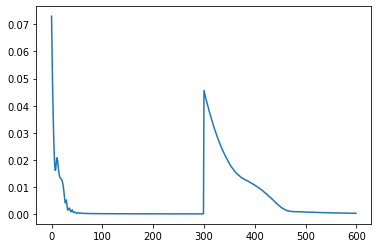

In [58]:
plt.plot(xlk_history)

In [59]:
rnn.eval()
xlk_test_predict, _ = rnn(xlk_X_test_cuda,hidden_state)
xlk_test_predict_cpu = xlk_test_predict.cpu().detach().numpy()

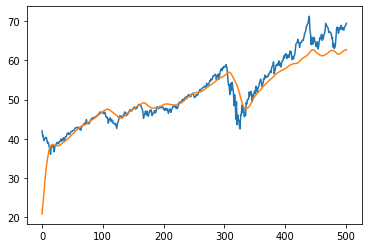

In [60]:
plt.plot(sc.inverse_transform(xlk_y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(xlk_test_predict_cpu.reshape(-1,1)))

In [61]:
print(f"RMSE：{np.sqrt(mean_squared_error(sc.inverse_transform(xlk_test_predict_cpu.reshape(-1,1)), sc.inverse_transform(xlk_y_test.reshape(-1,1))))}")

RMSE：3.3309176489493115


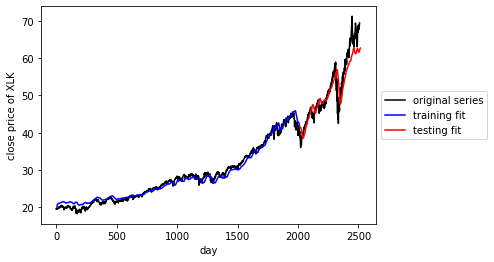

In [62]:
# plot original data
plt.plot(sc.inverse_transform(xlk_y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
xlk_train_pred, hidden_state = rnn(xlk_inputs_cuda, None)
xlk_train_pred_cpu = xlk_train_pred.cpu().detach().numpy()

# use hidden state from previous training data
xlk_test_predict, _ = rnn(xlk_X_test_cuda, hidden_state)
xlk_test_predict_cpu = xlk_test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
xlk_split_pt = int(xlk_X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, xlk_split_pt, 1), sc.inverse_transform(xlk_train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(xlk_split_pt, xlk_split_pt + len(xlk_test_predict_cpu), 1), sc.inverse_transform(xlk_test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('close price of XLK')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

##### For xlv

In [63]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [64]:
xlv_history = []
xlv_X_test_cuda = torch.tensor(xlv_X_test).float().cuda()
xlv_y_test_cuda = torch.tensor(xlv_y_test).float().cuda()

# we use all the data in one batch
xlv_inputs_cuda = torch.tensor(xlv_X_train).float().cuda()
xlv_labels_cuda = torch.tensor(xlv_y_train).float().cuda()


epochTest(num_epochs,xlv_inputs_cuda,xlv_labels_cuda,xlv_X_test_cuda,xlv_y_test_cuda,hidden_state,xlv_history)

epoch 0, loss 0.18725626170635223, eval loss 0.6067569255828857
epoch 1, loss 0.16742968559265137
epoch 2, loss 0.14871183037757874
epoch 3, loss 0.13091129064559937
epoch 4, loss 0.11331097781658173
epoch 5, loss 0.09627241641283035
epoch 6, loss 0.07919429242610931
epoch 7, loss 0.06294512003660202
epoch 8, loss 0.04827670380473137
epoch 9, loss 0.03764967992901802
epoch 10, loss 0.03428823873400688
epoch 11, loss 0.04286029934883118
epoch 12, loss 0.05080549046397209
epoch 13, loss 0.049117520451545715
epoch 14, loss 0.04171151667833328
epoch 15, loss 0.034384921193122864
epoch 16, loss 0.029929565265774727
epoch 17, loss 0.028090231120586395
epoch 18, loss 0.02766459994018078
epoch 19, loss 0.027840083464980125
epoch 20, loss 0.027494357898831367, eval loss 0.11214874684810638
epoch 21, loss 0.026263438165187836
epoch 22, loss 0.024045782163739204
epoch 23, loss 0.020836930721998215
epoch 24, loss 0.01725916564464569
epoch 25, loss 0.013135163113474846
epoch 26, loss 0.010602287948

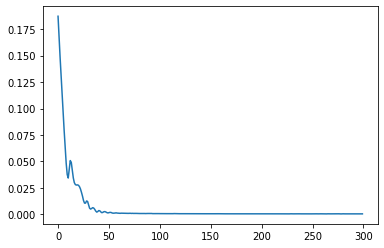

In [65]:
plt.plot(xlv_history)

In [66]:
rnn.eval()
xlv_test_predict, _ = rnn(xlv_X_test_cuda,hidden_state)
xlv_test_predict_cpu = xlv_test_predict.cpu().detach().numpy()

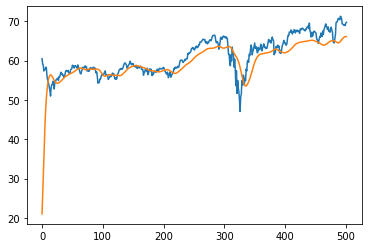

In [67]:
plt.plot(sc.inverse_transform(xlv_y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(xlv_test_predict_cpu.reshape(-1,1)))

In [68]:
print(f"RMSE：{np.sqrt(mean_squared_error(sc.inverse_transform(xlv_test_predict_cpu.reshape(-1,1)), sc.inverse_transform(xlv_y_test.reshape(-1,1))))}")

RMSE：3.9464387395115925


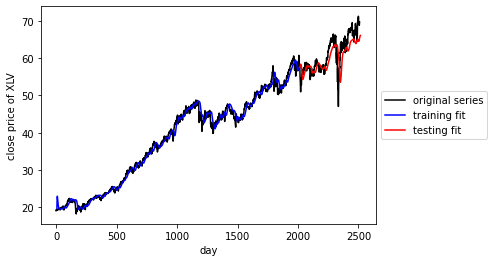

In [69]:
# plot original data
plt.plot(sc.inverse_transform(xlv_y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
xlv_train_pred, hidden_state = rnn(xlv_inputs_cuda, None)
xlv_train_pred_cpu = xlv_train_pred.cpu().detach().numpy()

# use hidden state from previous training data
xlv_test_predict, _ = rnn(xlv_X_test_cuda, hidden_state)
xlv_test_predict_cpu = xlv_test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
xlv_split_pt = int(xlv_X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, xlv_split_pt, 1), sc.inverse_transform(xlv_train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(xlv_split_pt, xlv_split_pt + len(xlv_test_predict_cpu), 1), sc.inverse_transform(xlv_test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('close price of XLV')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

##### For xlf

In [70]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [71]:
xlf_history = []
xlf_X_test_cuda = torch.tensor(xlf_X_test).float().cuda()
xlf_y_test_cuda = torch.tensor(xlf_y_test).float().cuda()

# we use all the data in one batch
xlf_inputs_cuda = torch.tensor(xlf_X_train).float().cuda()
xlf_labels_cuda = torch.tensor(xlf_y_train).float().cuda()


epochTest(num_epochs,xlf_inputs_cuda,xlf_labels_cuda,xlf_X_test_cuda,xlf_y_test_cuda,hidden_state,xlf_history)

epoch 0, loss 0.32219216227531433, eval loss 0.7060574293136597
epoch 1, loss 0.29664769768714905
epoch 2, loss 0.27158206701278687
epoch 3, loss 0.24673323333263397
epoch 4, loss 0.22091400623321533
epoch 5, loss 0.19313153624534607
epoch 6, loss 0.1639447808265686
epoch 7, loss 0.13248968124389648
epoch 8, loss 0.09935960918664932
epoch 9, loss 0.06642885506153107
epoch 10, loss 0.040295492857694626
epoch 11, loss 0.03441782668232918
epoch 12, loss 0.060111649334430695
epoch 13, loss 0.07413442432880402
epoch 14, loss 0.06188715994358063
epoch 15, loss 0.04619383439421654
epoch 16, loss 0.03487621992826462
epoch 17, loss 0.031209303066134453
epoch 18, loss 0.032264094799757004
epoch 19, loss 0.034696612507104874
epoch 20, loss 0.037553489208221436, eval loss 0.12678579986095428
epoch 21, loss 0.039392754435539246
epoch 22, loss 0.03945242986083031
epoch 23, loss 0.03741167113184929
epoch 24, loss 0.034350354224443436
epoch 25, loss 0.030468007549643517
epoch 26, loss 0.02565285377204

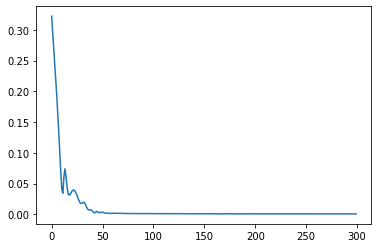

In [72]:
plt.plot(xlf_history)

In [73]:
rnn.eval()
xlf_test_predict, _ = rnn(xlf_X_test_cuda,hidden_state)
xlf_test_predict_cpu = xlf_test_predict.cpu().detach().numpy()

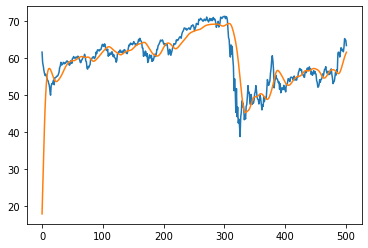

In [74]:
plt.plot(sc.inverse_transform(xlf_y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(xlf_test_predict_cpu.reshape(-1,1)))

In [75]:
print(f"RMSE：{np.sqrt(mean_squared_error(sc.inverse_transform(xlf_test_predict_cpu.reshape(-1,1)), sc.inverse_transform(xlf_y_test.reshape(-1,1))))}")

RMSE：4.459648141045666


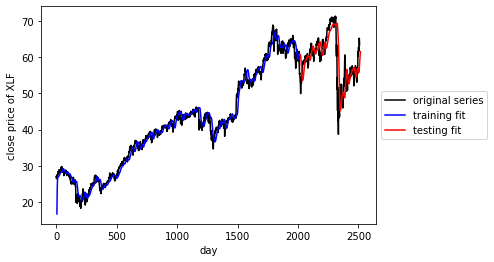

In [76]:
# plot original data
plt.plot(sc.inverse_transform(xlf_y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
xlf_train_pred, hidden_state = rnn(xlf_inputs_cuda, None)
xlf_train_pred_cpu = xlf_train_pred.cpu().detach().numpy()

# use hidden state from previous training data
xlf_test_predict, _ = rnn(xlf_X_test_cuda, hidden_state)
xlf_test_predict_cpu = xlf_test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
xlf_split_pt = int(xlf_X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, xlf_split_pt, 1), sc.inverse_transform(xlf_train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(xlf_split_pt, xlf_split_pt + len(xlf_test_predict_cpu), 1), sc.inverse_transform(xlf_test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('close price of XLF')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))

##### For xtn

In [77]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [78]:
xtn_history = []
xtn_X_test_cuda = torch.tensor(xtn_X_test).float().cuda()
xtn_y_test_cuda = torch.tensor(xtn_y_test).float().cuda()

# we use all the data in one batch
xtn_inputs_cuda = torch.tensor(xtn_X_train).float().cuda()
xtn_labels_cuda = torch.tensor(xtn_y_train).float().cuda()


epochTest(num_epochs,xtn_inputs_cuda,xtn_labels_cuda,xtn_X_test_cuda,xtn_y_test_cuda,hidden_state,xtn_history)

epoch 0, loss 0.26306119561195374, eval loss 0.5129876136779785
epoch 1, loss 0.2381388247013092
epoch 2, loss 0.21377505362033844
epoch 3, loss 0.18945741653442383
epoch 4, loss 0.16431757807731628
epoch 5, loss 0.1385050266981125
epoch 6, loss 0.1116761714220047
epoch 7, loss 0.08454439043998718
epoch 8, loss 0.0595940500497818
epoch 9, loss 0.04464200884103775
epoch 10, loss 0.052802231162786484
epoch 11, loss 0.0722782090306282
epoch 12, loss 0.07185474783182144
epoch 13, loss 0.05906173214316368
epoch 14, loss 0.04694889485836029
epoch 15, loss 0.039934705942869186
epoch 16, loss 0.03815387934446335
epoch 17, loss 0.03890782222151756
epoch 18, loss 0.039920009672641754
epoch 19, loss 0.03991100192070007
epoch 20, loss 0.038903288543224335, eval loss 0.07445239275693893
epoch 21, loss 0.03657400235533714
epoch 22, loss 0.0325610525906086
epoch 23, loss 0.027178244665265083
epoch 24, loss 0.021785946562886238
epoch 25, loss 0.017319297417998314
epoch 26, loss 0.01560947671532631
epo

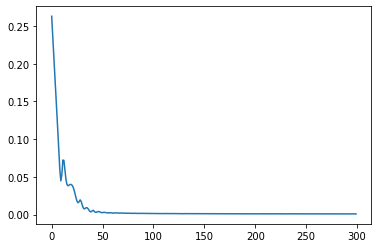

In [79]:
plt.plot(xtn_history)

In [80]:
rnn.eval()
xtn_test_predict, _ = rnn(xtn_X_test_cuda,hidden_state)
xtn_test_predict_cpu = xtn_test_predict.cpu().detach().numpy()

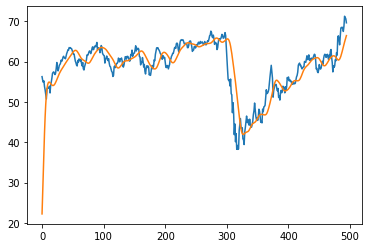

In [81]:
plt.plot(sc.inverse_transform(xtn_y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(xtn_test_predict_cpu.reshape(-1,1)))

In [82]:
print(f"RMSE：{np.sqrt(mean_squared_error(sc.inverse_transform(xtn_test_predict_cpu.reshape(-1,1)), sc.inverse_transform(xtn_y_test.reshape(-1,1))))}")

RMSE：3.985145001037061


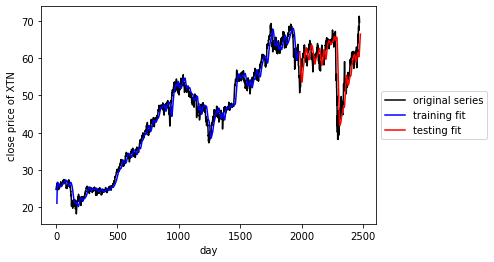

In [83]:
# plot original data
plt.plot(sc.inverse_transform(xtn_y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
xtn_train_pred, hidden_state = rnn(xtn_inputs_cuda, None)
xtn_train_pred_cpu = xtn_train_pred.cpu().detach().numpy()

# use hidden state from previous training data
xtn_test_predict, _ = rnn(xtn_X_test_cuda, hidden_state)
xtn_test_predict_cpu = xtn_test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
xtn_split_pt = int(xtn_X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, xtn_split_pt, 1), sc.inverse_transform(xtn_train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(xtn_split_pt, xtn_split_pt + len(xtn_test_predict_cpu), 1), sc.inverse_transform(xtn_test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('close price of XTN')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))

## Zoom in XLK during Covid-19 period:

In all modeling processes I have done for the technology sector above, I found that tech stocks have performed surprisingly well during the covid-19 period. So in this part, I focus on the year from December 2019 to December 2020 and try to build a prediction model for this particular period.

### Pre-processing

In [4]:
start_1 = datetime.datetime(2019, 12, 1)
end_1 = datetime.datetime(2020, 12, 1)
pd.set_option('display.precision', 2)
xlk_1 = web.DataReader("XLK", 'yahoo', start_1, end_1)
xlf_1 = web.DataReader("XLF",'yahoo', start_1, end_1)
xlv_1 = web.DataReader("XLV",'yahoo', start_1, end_1)
xtn_1 = web.DataReader("XTN",'yahoo', start_1, end_1)

In [85]:
xlk_1.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-02,88.20,86.52,88.20,86.90,1.16e+07,85.74
2019-12-03,86.19,85.16,85.53,86.13,1.12e+07,84.98
2019-12-04,86.76,86.35,86.69,86.48,6.91e+06,85.33
2019-12-05,86.87,86.39,86.79,86.80,7.81e+06,85.64
2019-12-06,87.84,87.39,87.46,87.76,9.20e+06,86.59


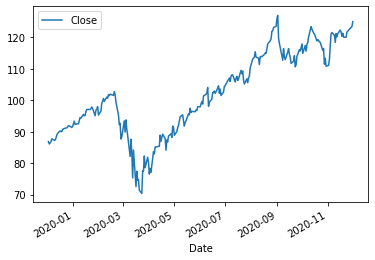

In [86]:
xlk_1.plot(y = ['Close'])

In [87]:
xlk_1_cl = xlk_1.Close.values

In [88]:
xlk_1_cl = xlk_1_cl.reshape(xlk_1_cl.shape[0], 1)
xlk_1_cl = sc.fit_transform(xlk_1_cl)

In [89]:
xlk_1_X, xlk_1_y = processData(xlk_1_cl, 7)

In [90]:
xlk_1_X_train, xlk_1_X_test = xlk_1_X[:int(xlk_1_X.shape[0]*0.80)],xlk_1_X[int(xlk_1_X.shape[0]*0.80):]
xlk_1_y_train, xlk_1_y_test = xlk_1_y[:int(xlk_1_y.shape[0]*0.80)],xlk_1_y[int(xlk_1_y.shape[0]*0.80):]
print(xlk_1_X_train.shape[0])
print(xlk_1_X_test.shape[0])
print(xlk_1_y_train.shape[0])
print(xlk_1_y_test.shape[0])

# reshaping
xlk_1_X_train = np.reshape(xlk_1_X_train, (xlk_1_X_train.shape[0], 1, xlk_1_X_train.shape[1]))
xlk_1_X_test = np.reshape(xlk_1_X_test, (xlk_1_X_test.shape[0], 1, xlk_1_X_test.shape[1]))

196
49
196
49


### Creating the RNN

In [91]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 32
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 64
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [92]:
rnn

RNN(
  (rnn): LSTM(7, 32, num_layers=3, dropout=0.1)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [93]:
xlk_1_history = []
xlk_1_X_test_cuda = torch.tensor(xlk_1_X_test).float().cuda()
xlk_1_y_test_cuda = torch.tensor(xlk_1_y_test).float().cuda()

# we use all the data in one batch
xlk_1_inputs_cuda = torch.tensor(xlk_1_X_train).float().cuda()
xlk_1_labels_cuda = torch.tensor(xlk_1_y_train).float().cuda()


epochTest(num_epochs,xlk_1_inputs_cuda,xlk_1_labels_cuda,xlk_1_X_test_cuda,xlk_1_y_test_cuda,hidden_state,xlk_1_history)

epoch 0, loss 0.12121856212615967, eval loss 0.3836297392845154
epoch 1, loss 0.11314254999160767
epoch 2, loss 0.10584406554698944
epoch 3, loss 0.09875569492578506
epoch 4, loss 0.09245678037405014
epoch 5, loss 0.08588390797376633
epoch 6, loss 0.07984482496976852
epoch 7, loss 0.07347139716148376
epoch 8, loss 0.06802161037921906
epoch 9, loss 0.06267371028661728
epoch 10, loss 0.05717260017991066
epoch 11, loss 0.05244075879454613
epoch 12, loss 0.047944165766239166
epoch 13, loss 0.0441284105181694
epoch 14, loss 0.040989749133586884
epoch 15, loss 0.03929407522082329
epoch 16, loss 0.03795737028121948
epoch 17, loss 0.03824232146143913
epoch 18, loss 0.03911423683166504
epoch 19, loss 0.04054146632552147
epoch 20, loss 0.041027408093214035, eval loss 0.058285679668188095
epoch 21, loss 0.04216499626636505
epoch 22, loss 0.04111078381538391
epoch 23, loss 0.0391947403550148
epoch 24, loss 0.038034047931432724
epoch 25, loss 0.03615835681557655
epoch 26, loss 0.03543805703520775
e

In [94]:
rnn.eval()
xlk_1_test_predict, _ = rnn(xlk_1_X_test_cuda,hidden_state)
xlk_1_test_predict_cpu = xlk_1_test_predict.cpu().detach().numpy()

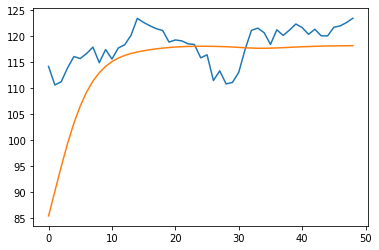

In [95]:
plt.plot(sc.inverse_transform(xlk_1_y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(xlk_1_test_predict_cpu.reshape(-1,1)))

In [96]:
from sklearn.metrics import mean_squared_error
print(f"RMSE：{np.sqrt(mean_squared_error(sc.inverse_transform(xlk_1_test_predict_cpu.reshape(-1,1)), sc.inverse_transform(xlk_1_y_test.reshape(-1,1))))}")

RMSE：7.302684589966653


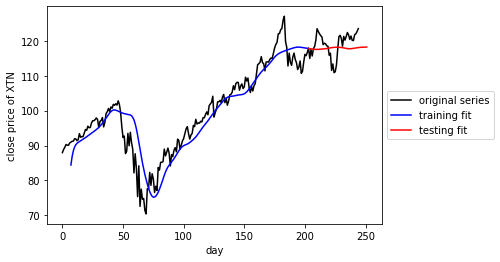

In [97]:
# plot original data
plt.plot(sc.inverse_transform(xlk_1_y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
xlk_1_train_pred, hidden_state = rnn(xlk_1_inputs_cuda, None)
xlk_1_train_pred_cpu = xlk_1_train_pred.cpu().detach().numpy()

# use hidden state from previous training data
xlk_1_test_predict, _ = rnn(xlk_1_X_test_cuda, hidden_state)
xlk_1_test_predict_cpu = xlk_1_test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
xlk_1_split_pt = int(xlk_1_X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, xlk_1_split_pt, 1), sc.inverse_transform(xlk_1_train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(xlk_1_split_pt, xlk_1_split_pt + len(xlk_1_test_predict_cpu), 1), sc.inverse_transform(xlk_1_test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('close price of XTN')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))

The above establishes a basic model for the stock forecast of the COVID-19 in XLK sector. This model can be further refined to improve accuracy and can be looked at in conjunction with stock data for other periods of specific illness, perhaps exist regularity.

# Part 3: Other Exploration of the 4 Sectors

### Explore the relative change

In [5]:
openPrice = xlk_1['Close'][0]
xlk_1['relative'] = (xlk_1['Close'] - openPrice)/openPrice

In [6]:
for etf in [xlk_1, xtn_1, xlv_1, xlf_1]:
  openPrice=etf['Close'][0]
  etf['relative'] = (etf['Close'] - openPrice)/openPrice
  print(etf.head())

             High    Low   Open  Close    Volume  Adj Close  relative
Date                                                                 
2019-12-02  88.20  86.52  88.20  86.90  1.16e+07      85.54  0.00e+00
2019-12-03  86.19  85.16  85.53  86.13  1.12e+07      84.78 -8.86e-03
2019-12-04  86.76  86.35  86.69  86.48  6.91e+06      85.13 -4.83e-03
2019-12-05  86.87  86.39  86.79  86.80  7.81e+06      85.44 -1.15e-03
2019-12-06  87.84  87.39  87.46  87.76  9.20e+06      86.39  9.90e-03
             High    Low   Open  Close   Volume  Adj Close  relative
Date                                                                
2019-12-02  64.40  63.71  64.40  63.75   7500.0      62.95  0.00e+00
2019-12-03  63.05  62.48  63.04  62.54  22300.0      61.75 -1.90e-02
2019-12-04  63.33  62.73  62.73  62.81  44400.0      62.02 -1.47e-02
2019-12-05  62.91  62.75  62.82  62.88   4800.0      62.09 -1.36e-02
2019-12-06  63.95  63.63  63.95  63.73   6000.0      62.93 -3.14e-04
              High     Low 

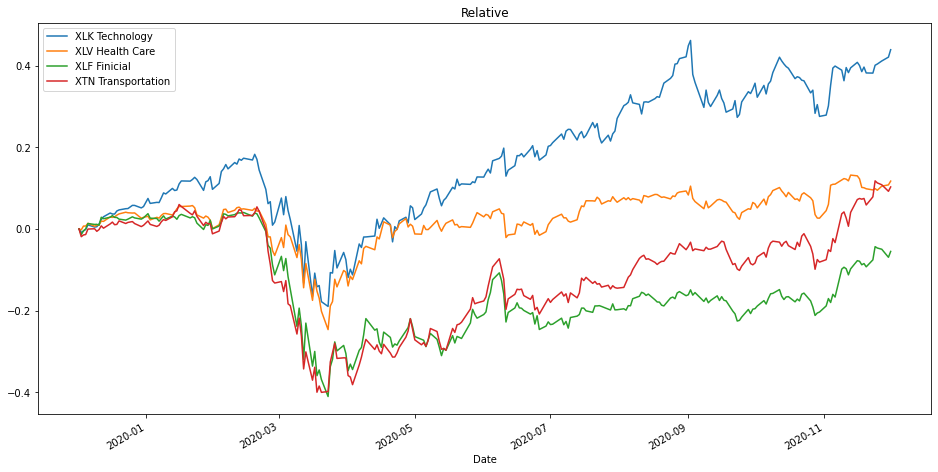

In [7]:
xlk_1['relative'].plot(label='XLK Technology',figsize=(16,8),title='Relative')
xlv_1['relative'].plot(label='XLV Health Care')
xlf_1['relative'].plot(label='XLF Finicial')
xtn_1['relative'].plot(label='XTN Transportation')
plt.legend()

Looks like XLK and XTN are parallel, same with XLV and XLF.  Use Person Relation to check if they have relationship.

In [24]:
xlk_1['relative'][104:]

Date
2020-05-01    0.02
2020-05-04    0.04
2020-05-05    0.05
2020-05-06    0.06
2020-05-07    0.07
              ... 
2020-11-24    0.40
2020-11-25    0.40
2020-11-27    0.41
2020-11-30    0.42
2020-12-01    0.44
Name: relative, Length: 149, dtype: float64

In [25]:
np.corrcoef(xlk_1['relative'][104:], xtn_1['relative'][104:])

array([[1.        , 0.89665583],
       [0.89665583, 1.        ]])

In [26]:
np.corrcoef(xlf_1['relative'][104:], xlv_1['relative'][104:])

array([[1.        , 0.79754936],
       [0.79754936, 1.        ]])

The lowest price and the time of the lowest price in XLK.

In [8]:
xlk_1[xlk_1['Close'] == xlk_1['Close'].min()]

,High,Low,Open,Close,Volume,Adj Close,relative
Date,,,,,,,
2020-03-23,72.22,68.1,70.69,70.4,4.25e+07,70.05,-0.19


Volume

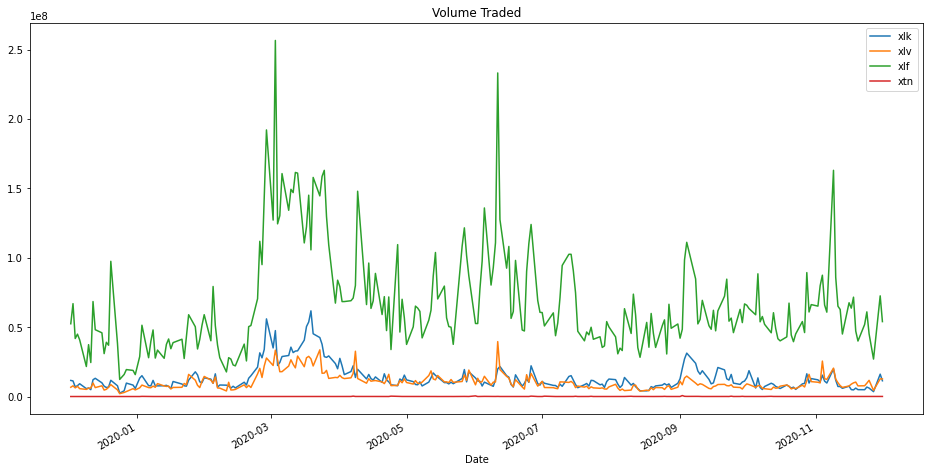

In [9]:
xlk_1['Volume'].plot(label='xlk',figsize=(16,8),title='Volume Traded')
xlv_1['Volume'].plot(label='xlv')
xlf_1['Volume'].plot(label='xlf')
xtn_1['Volume'].plot(label= 'xtn')
plt.legend()

MA (Moving Averages)：

It is also a good model to fit the performance of XLK.

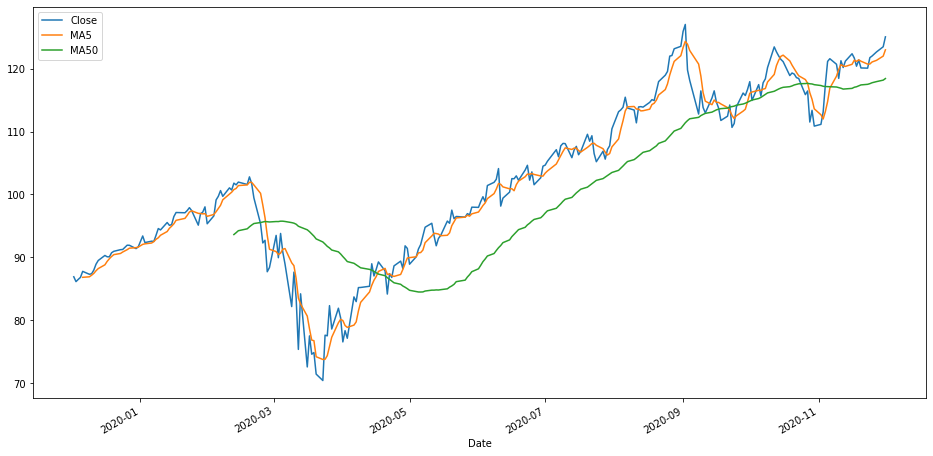

In [17]:
xlk_1['MA5'] = xlk_1['Close'].rolling(5).mean()
xlk_1['MA50'] = xlk_1['Close'].rolling(50).mean()
xlk_1[['Close','MA5','MA50']].plot(label='xlv',figsize=(16,8))

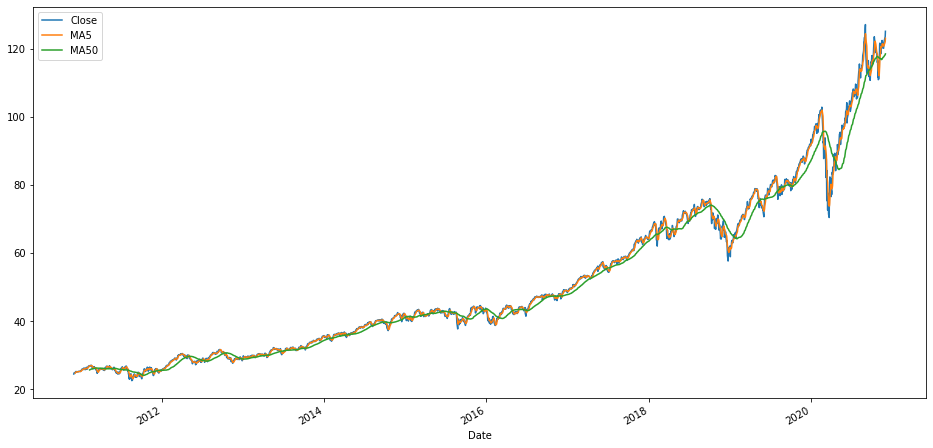

In [103]:
xlk['MA5'] = xlk['Close'].rolling(5).mean()
xlk['MA50'] = xlk['Close'].rolling(50).mean()
xlk[['Close','MA5','MA50']].plot(label='xlv',figsize=(16,8))

Daily Percentage Change

In [10]:
xlk_1['returns'] = xlk_1['Close'].pct_change(1)
xlf_1['returns'] = xlf_1['Close'].pct_change(1)
xlv_1['returns'] = xlv_1['Close'].pct_change(1)
xtn_1['returns'] = xtn_1['Close'].pct_change(1)

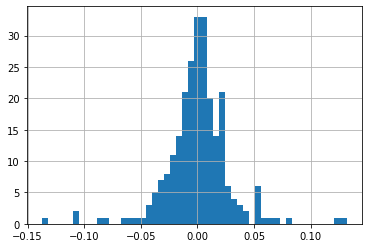

In [11]:
xlf_1['returns'].hist(bins=50)

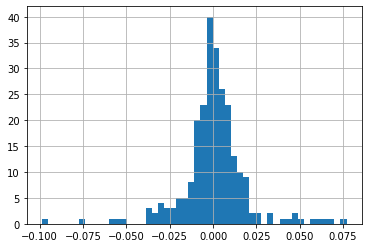

In [12]:
xlv_1['returns'].hist(bins=50)

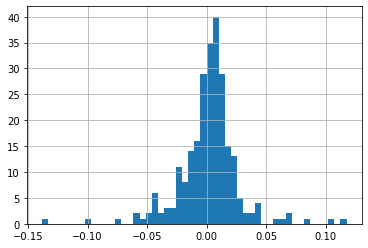

In [13]:
xlk_1['returns'].hist(bins=50)

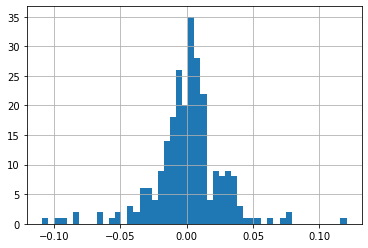

In [14]:
xtn_1['returns'].hist(bins=50)

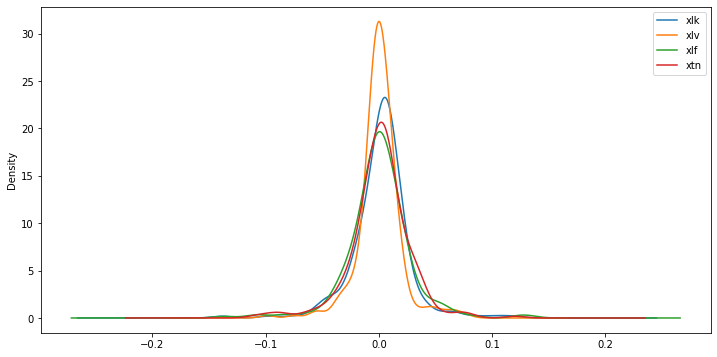

In [15]:
xlk_1['returns'].plot(kind='kde',label='xlk',figsize=(12,6))
xlv_1['returns'].plot(kind='kde',label='xlv')
xlf_1['returns'].plot(kind='kde',label='xlf')
xtn_1['returns'].plot(kind='kde',label='xtn')
plt.legend()

Sharp Ratio: In finance, the Sharpe ratio measures the performance of an investment compared toa risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of theinvestment and the risk-free return, divided by the standard deviation of the investment.

In [10]:
start_2 = datetime.datetime(2017, 1, 1)
end_2 = datetime.datetime(2018, 1, 1)
pd.set_option('display.precision', 2)
xlk_2 = web.DataReader("XLK", 'yahoo', start_2, end_2)
xlf_2 = web.DataReader("XLF",'yahoo', start_2, end_2)
xlv_2 = web.DataReader("XLV",'yahoo', start_2, end_2)
xtn_2 = web.DataReader("XTN",'yahoo', start_2, end_2)

In [11]:
xlk_2['returns'] = xlk_2['Close'].pct_change(1)
xlf_2['returns'] = xlf_2['Close'].pct_change(1)
xlv_2['returns'] = xlv_2['Close'].pct_change(1)
xtn_2['returns'] = xtn_2['Close'].pct_change(1)

In [12]:
xlkSR_2 = xlk_2['returns'].mean() / xlk_2['returns'].std()
xlkASR_2 = xlkSR_2*(252**0.5)
print(xlkASR_2)
xlvSR_2 = xlv_2['returns'].mean() / xlv_2['returns'].std()
xlvASR_2 = xlvSR_2*(252**0.5)
print(xlvASR_2)
xlfSR_2 = xlf_2['returns'].mean() / xlf_2['returns'].std()
xlfASR_2 = xlfSR_2*(252**0.5)
print(xlfASR_2)
xtnSR_2 = xtn_2['returns'].mean() / xtn_2['returns'].std()
xtnASR_2 = xtnSR_2*(252**0.5)
print(xtnASR_2)

2.685355646540365
2.001388465525056
1.3875225190490352
1.2959475105740543


In [16]:
xlkSR_1 = xlk_1['returns'].mean() / xlk_1['returns'].std()
xlkASR_1 = xlkSR_1*(252**0.5)
print(xlkASR_1)
xlvSR_1 = xlv_1['returns'].mean() / xlv_1['returns'].std()
xlvASR_1 = xlvSR_1*(252**0.5)
print(xlvASR_1)
xlfSR_1 = xlf_1['returns'].mean() / xlf_1['returns'].std()
xlfASR_1 = xlfSR_1*(252**0.5)
print(xlfASR_1)
xtnSR_1 = xtn_1['returns'].mean() / xtn_1['returns'].std()
xtnASR_1 = xtnSR_1*(252**0.5)
print(xtnASR_1)

1.1081821740479147
0.5151548444470843
0.10322291032236483
0.44411647964472917
